<img src="IMG/logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales - Segundo Cuatrimestre 2025

# TS8: Filtrado digital lineal de ECG
#### Matías Cassino 

# Consignas
Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Ayuda: Los detalles de cómo acceder a ecg.mat los pueden encontrar en lectura_sigs.py

Archivo ECG.mat
(variables)

- ecg_lead: Registro de ECG muestreado a fs = 1 kHz durante una prueba de esfuerzo
- qrs_pattern1: Complejo de ondas QRS normal
- heartbeat_pattern1: Latido normal
- heartbeat_pattern2: Latido de origen ventricular
- qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos

Se pide:

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.

Ayuda: Utilice los resultados del ancho de banda estimado del ECG en la Tarea Semanal 5. 

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.

Ayuda: Para los filtros IIR adopte las aproximaciones de módulo de máxima planicidad, Chebyshev y Cauer. Para los FIR, utilice las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez. Todos implementados en SciPy.Signal

d)  Evalúe el rendimiento de los filtros que haya diseñado:

1. Verifique que filtra las señales interferentes.
2. Verifique que es inocuo en las zonas donde no hay interferentes.

# Introducción
En este trabajo se aborda el diseño y evaluación de filtros digitales de tipo FIR (cuadrados mínimos y Parks-Mc Clellan) e IIR (Butterworth y Cauer) para el procesamiento de una señal de ECG afectada por interferencia de baja y alta frecuencia, provenientes de la respiración y la actividad muscular respectivamente. Concretamente, se implementa un pasa banda que aisla el 99% de la energía en un ancho de banda definido entre 0.9 y 35 Hz con un ripple de 1 dB y se atenúa el resto de frecuencias con 40 dB. De esta forma, se logra cumplir la plantilla y preservar la morfología de la señal en conjunto a consideraciones respecto de la fase y sus efectos.

# Desarrollo experimental

In [1]:
#%% Módulos
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio
from matplotlib import patches
from pytc2.sistemas_lineales import plot_plantilla

#%% Funciones
plt.close('all')

def rta_frec_fase_y_retardo_fir(b,worN,fs,filter_type,wp,ws,alpha_p,alpha_s,f_aprox):
    # worN define puntos de evaluación logarítmicamente espaciados delde 10^(-2) a 10^(2) de RTA frec hasta Nyquist
    w,h=sig.freqz(b=b,worN=worN, fs=fs) 
    phase=np.unwrap(np.angle(h)) 
    w_rad=w/(fs/2)*np.pi # 
    gd=-np.diff(phase)/np.diff(w_rad)

    plt.figure(figsize=(12,10))

    #Magnitud
    plt.subplot(3,1,1)
    plt.plot(w, 20*np.log10(abs(h)),label=f_aprox)
    plot_plantilla(filter_type=filter_type,fpass=wp,ripple=alpha_p,fstop=ws,attenuation=alpha_s,fs=fs) 
    plt.title('Respuesta en Magnitud')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Fase
    plt.subplot(3,1,2)
    plt.plot(w, phase,label=f_aprox)
    plt.title('Fase')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, which='both', ls=':')
    plt.legend()


    # Retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd,label=f_aprox)
    plt.title('Retardo de Grupo')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    
    plt.tight_layout()

    return w,h,phase,gd

def rta_frec_fase_y_retardo_iir(sos,worN,fs,filter_type,wp,ws,alpha_p,alpha_s,f_aprox):
    # worN define puntos de evaluación logarítmicamente espaciados delde 10^(-2) a 10^(2) de RTA frec hasta Nyquist
    w,h=sig.freqz_sos(sos=sos,worN=worN, fs=fs) 
    phase=np.unwrap(np.angle(h)) 
    w_rad=w/(fs/2)*np.pi # 
    gd=-np.diff(phase)/np.diff(w_rad)

    plt.figure(figsize=(12,10))

    #Magnitud
    plt.subplot(3,1,1)
    plt.plot(w, 2*(20*np.log10(abs(h))),label=f_aprox)
    plot_plantilla(filter_type=filter_type,fpass=wp,ripple=alpha_p,fstop=ws,attenuation=alpha_s,fs=fs) 
    plt.title('Respuesta bidireccional en Magnitud')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('|H(jω)| [dB]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Fase
    plt.subplot(3,1,2)
    plt.plot(w, phase,label=f_aprox)
    plt.title('Fase')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Fase [rad]')
    plt.grid(True, which='both', ls=':')
    plt.legend()


    # Retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd,label=f_aprox)
    plt.title('Retardo de Grupo')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    
    plt.tight_layout()

    return w,h,phase,gd

# Análisis de resultados

A) Analizando los resultados de la TS5, se pondera un ancho de banda que contiene el 99% de la energía entre 0.5 y 35 Hz aproximadamente. En consecuencia, se establece la siguiente plantilla de diseño.

In [2]:
#%% Plantilla de diseño
fs=1000 # Hz
nyq_frec=fs/2
wp= (0.9, 35) #  frecuencia de corte/paso [Hz]
ws= (0.1, 37.5) #  frecuencia de stop [Hz]

ripple=1 #[dB]
atenuacion=40 #[dB]
alpha_p_FIR= ripple
alpha_s_FIR=atenuacion
# Divido por dos porque lo aplico bidireccional
alpha_p_IIR= ripple/2 #atenuacion maxima a la w_corte = alfa_max (perdidas en banda paso [db])
alpha_s_IIR= atenuacion/2 #atenuacion minima a la w_paso = alfa_min (minima atenuacion requerida en bamda de paso[db])

# Plantilla normalizada a Nyquist en dB
frecs = np.array([0.0, ws[0], wp[0], wp[1], ws[1], nyq_frec])/nyq_frec

filter_type=['lowpass', 'highpass', 'bandpass', 'bandstop']
f_aprox_FIR=['Win','LS','PM']
f_aprox_IIR=['butter','cheby1','cheby1','cauer']

worN=np.logspace(-2,2,2000)

B) Se considera un ancho de banda más acotado en su límite inferior (0.9 Hz) de baja frecuencia debido a la interferencia, como movimiento en la línea de base, derivada de las bruscas oscilaciones temporales características de la respiración. Por otro lado, en alta frecuencia la delimitación del ancho de banda (35 Hz) se asocia a la interferencia, en menor magnitud, de la actividad muscular. De esta forma, se pretende un transción vertiginosa entre bandas para la cota inferior y una transición más permisiva para el límite superior, definiéndose así las frecuencia de stop en 0.1 y 37.5 Hz. En efecto, se establece una atenuacion máxima de 1 dB para definir las perdidas admitidas en banda paso, y una atenuacion mínima de 40 dB impuesta en la banda de rechazo a fin de suprimir las interferencias descriptas y obtener una señal de ECG filtrada semejante en suavidad y línea de base a los latidos promedio.

C) Se diseñan los filtros Butterworth (máxima planicidad) y Cauer de tipo IIR, los cuales aproximan el módulo en detrimento de la fase, son recursivos y poseen bajo costo computacional, y las metodologías de cuadrados mínimos y Parks-Mc Clellan-Ramez de tipo FIR, que poseen fase lineal, demora constante, son no recursivos y conllevan elevado costo computacional. Posteriormente, se analiza la respuesta en frecuencia de acuerdo a la plantilla de diseño. 
Cabe destacar que los filtros IIR se aplican de forma bidireccional para evitar distorsión de fase, haciéndola nula, y se pondera la partición de la atenuación para no duplicarla, por ende, el gráfico de magnitud es el que representa tal efecto mientras que los de fase y demora solo describen el efecto de la aplicación unidireccional.

In [3]:
 #%% Filtros FIR
pesos_ls=[70,0.3,20]
deseado_ls=[0,0, 1,1, 0,0]
cant_coef_ls=1129 #impar pq es tipo 2
retardo_ls=(cant_coef_ls-1)//2
fir_ls=sig.firls(numtaps=cant_coef_ls, bands=frecs, desired=deseado_ls,weight=pesos_ls)

pesos_pm=[88,7,90]
cant_coef_pm=1061 #impar pq es tipo 2
retardo_pm=(cant_coef_pm-1)//2
deseado_pm=[0,1,0]
fir_pm=sig.remez(numtaps=cant_coef_pm, bands=frecs, desired=deseado_pm, fs=2,weight=pesos_pm)
#nfreq define cant. puntos en frecuencia para interpolar (mejora la resolución)

#%% Filtros IIR para aproximaciones de módulo
mi_sos_butter=sig.iirdesign(wp=wp,ws=ws,gpass=alpha_p_IIR,gstop=alpha_s_IIR,analog=False,ftype=f_aprox_IIR[0],output='sos',fs=fs)

mi_sos_cauer=sig.iirdesign(wp=wp,ws=ws,gpass=alpha_p_IIR,gstop=alpha_s_IIR,analog=False,ftype=f_aprox_IIR[3],output='sos',fs=fs)

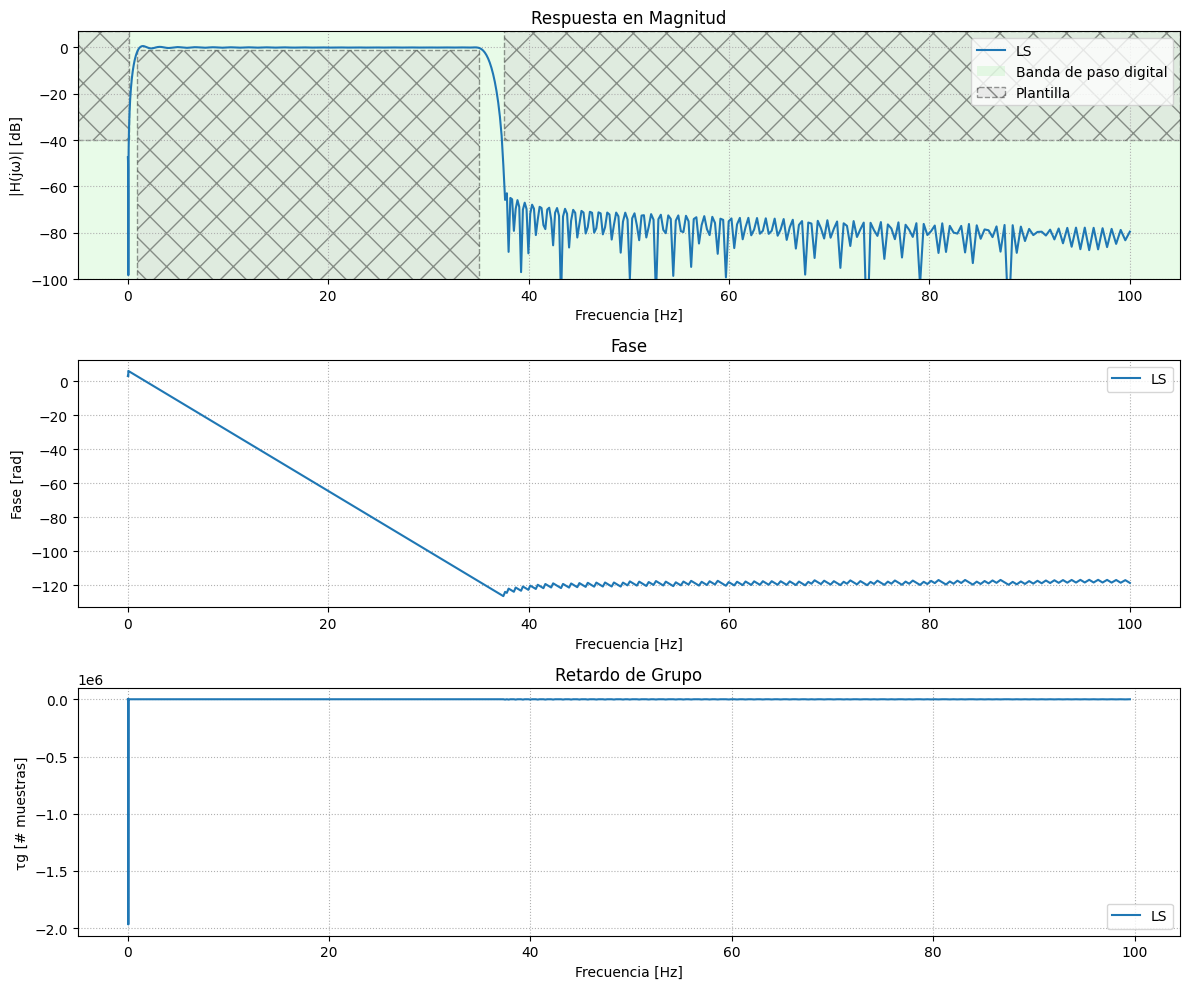

In [4]:
#%% Gráficos de cuadrados mínimos
w_ls,h_ls,phase_ls,gd_ls=rta_frec_fase_y_retardo_fir(b=fir_ls,worN=worN,fs=fs,filter_type=filter_type[2],wp=wp,ws=ws,alpha_p=alpha_p_FIR,alpha_s=alpha_s_FIR,f_aprox=f_aprox_FIR[1])

- Se observa que el filtro es óptimo en banda de paso por su planicidad excepto en el codo de transición de la banda de rechazo (0.9 Hz) donde presenta una leve atenuación mayor a la impuesta. Con respecto a su fase, esta es lineal, y, por lo tanto, la demora es constante.

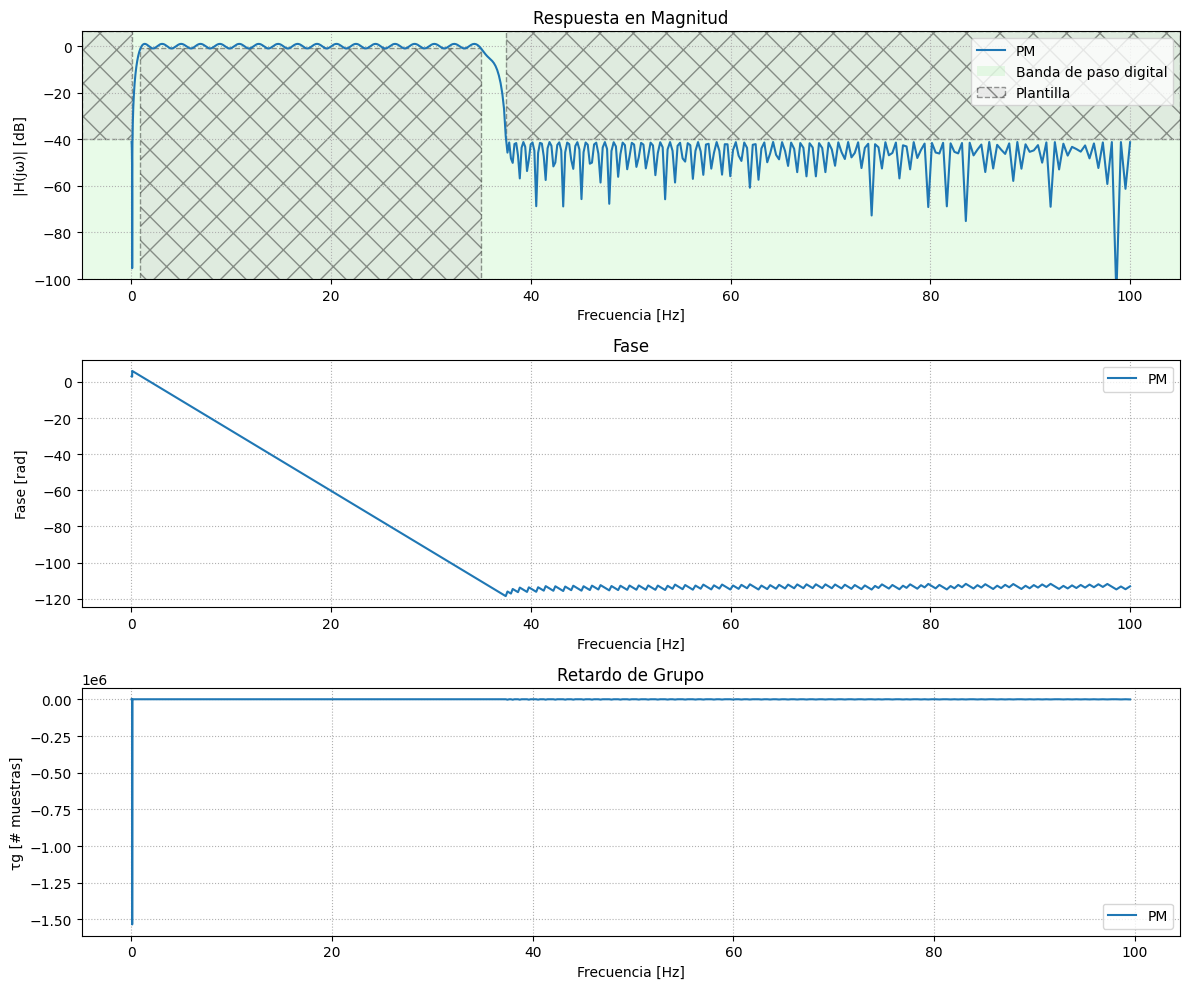

In [5]:
#%% Gráficos de Parks-Mc Clellan-Remez
w_pm,h_pm,phase_pm,gd_pm=rta_frec_fase_y_retardo_fir(b=fir_pm,worN=worN,fs=fs,filter_type=filter_type[2],wp=wp,ws=ws,alpha_p=alpha_p_FIR,alpha_s=alpha_s_FIR,f_aprox=f_aprox_FIR[2])

- Se exhibe un equiripple adecuado en las bandas de paso y rechazo, lo cual implica el cumplimiento de las atenuaciones impuestas en la plantilla de diseño en conjunto a los pesos establecidos. Al igual que en el filtro previamente estudiado, la fase es lineal en la banda de paso y su retardo es constante dado su caráter FIR. Cabe enfatizarse que la segunda transición no posee carácter lineal inicialmente.

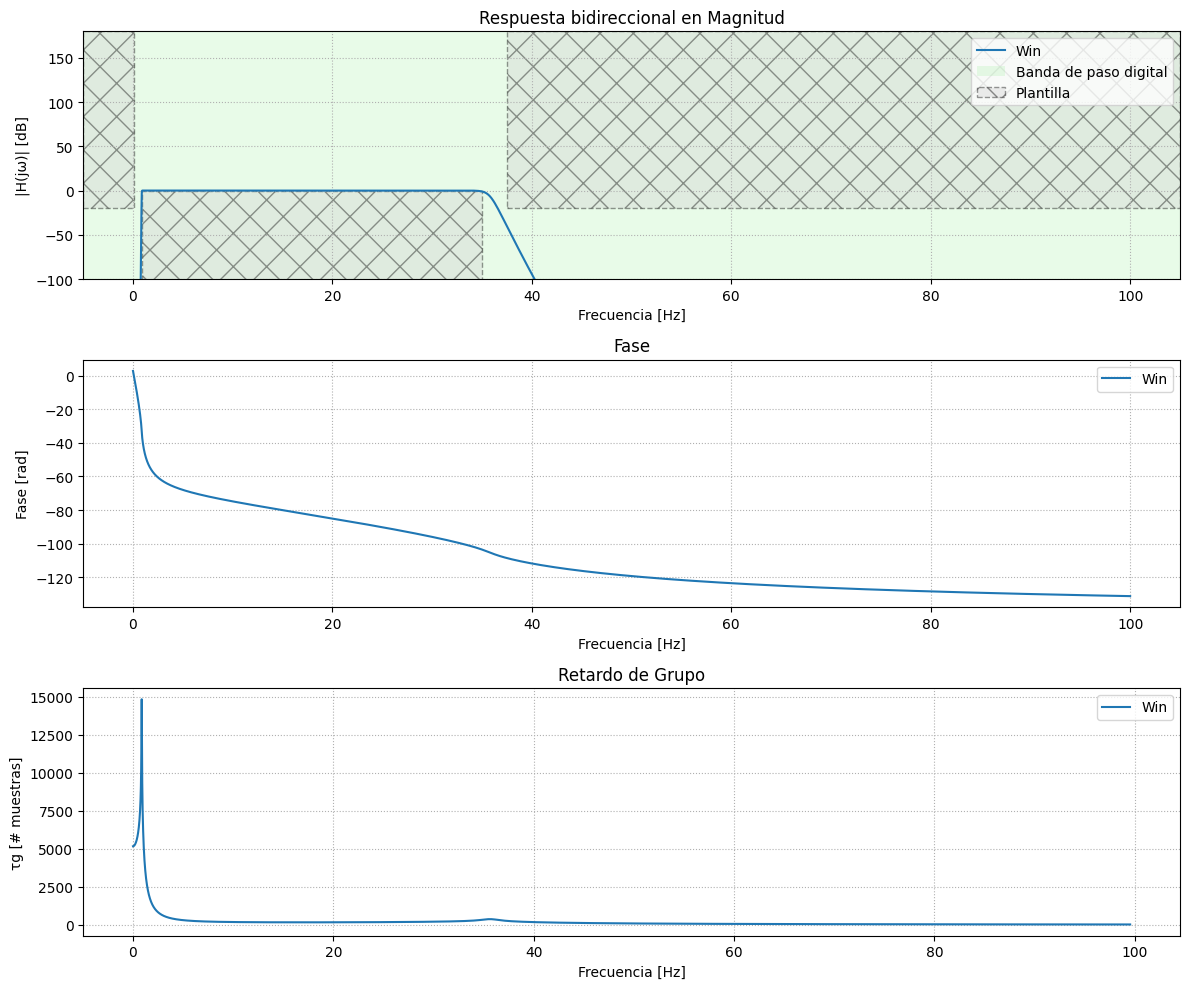

In [6]:
# Gráficos de Butterworth
w_butter,h_butter,phase_butter,gd_butter=rta_frec_fase_y_retardo_iir(sos=mi_sos_butter,worN=worN,fs=fs,filter_type=filter_type[2],wp=wp,ws=ws,alpha_p=alpha_p_IIR,alpha_s=alpha_s_IIR,f_aprox=f_aprox_FIR[0])

- Se presenta una respuesta de módulo que cumple idóneamente la plantilla de diseño ya que posee atenuación más acentuada que la establecida en la banda de rechazo, y no tiene ripple significativo en la banda de paso ya que se ajusta holgadamente a las condiciones. Esto se debe a su carácter de respuesta de módulo con máxima planicidad.

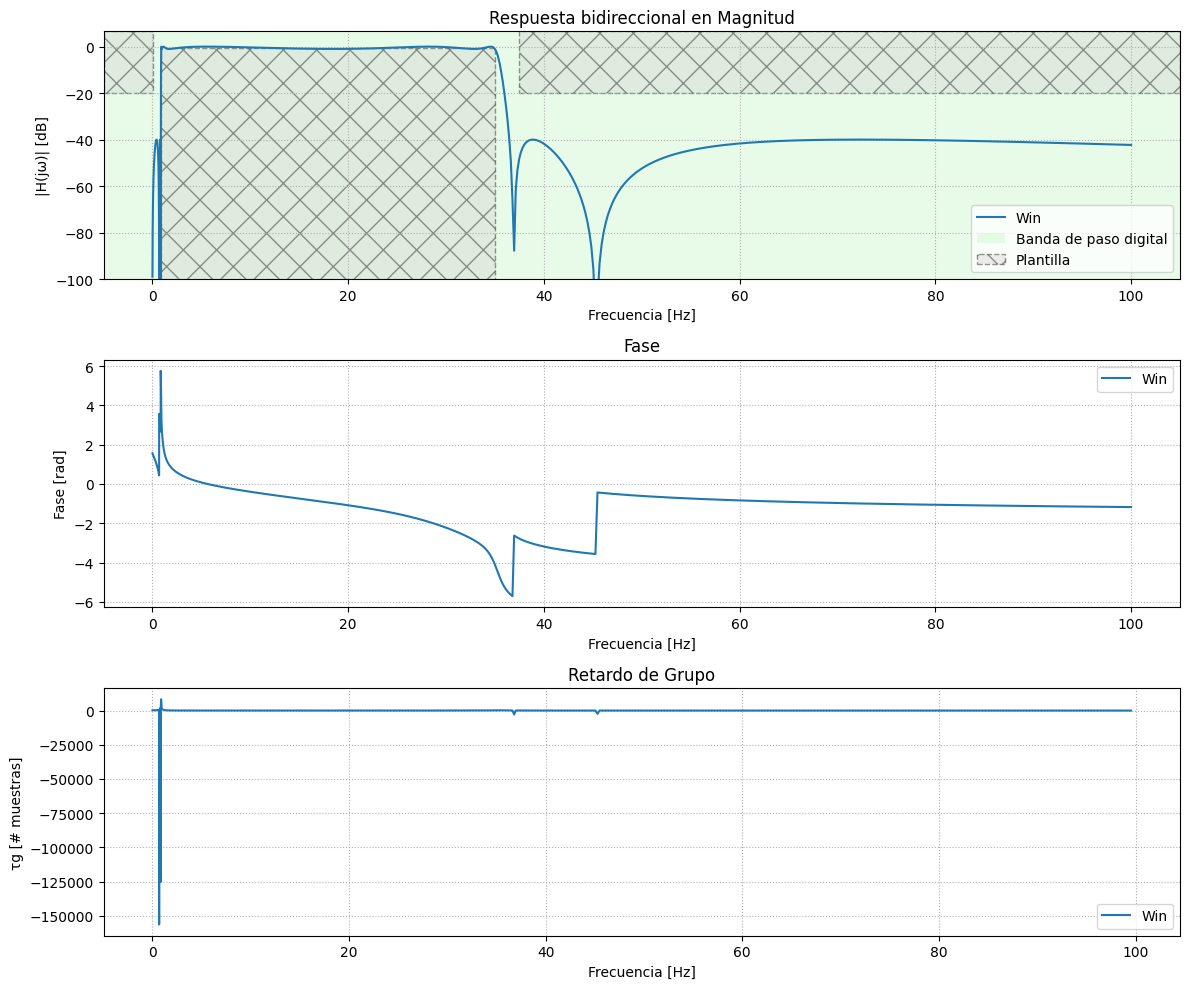

In [7]:
# Gráficos de Cauer
w_cauer,h_cauer,phase_cauer,gd_cauer=rta_frec_fase_y_retardo_iir(sos=mi_sos_cauer,worN=worN,fs=fs,filter_type=filter_type[2],wp=wp,ws=ws,alpha_p=alpha_p_IIR,alpha_s=alpha_s_IIR,f_aprox=f_aprox_FIR[0])

- Se expone una respuesta con equiripple en ambas bandas, lo cual es característico de la clase de filtro. A su vez, la respuesta de módulo se ajusta perfectamente a la plantilla de diseño ya que se alcanzan los valores de -40 dB de atenuación y - 1 dB de ripple en banda de paso, tal como lo impuesto.

D) Se enumeran las imágenes obtenidas en orden crecientes del 1 al 5.

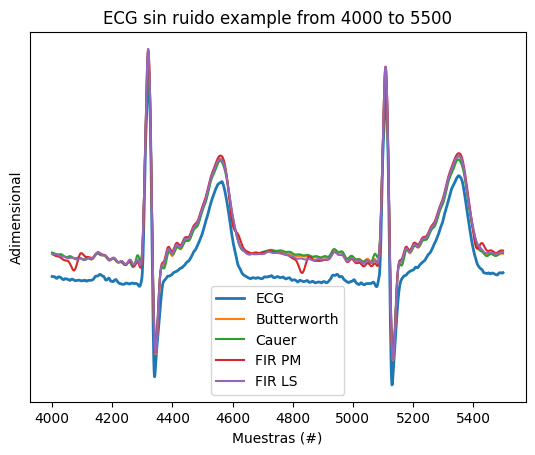

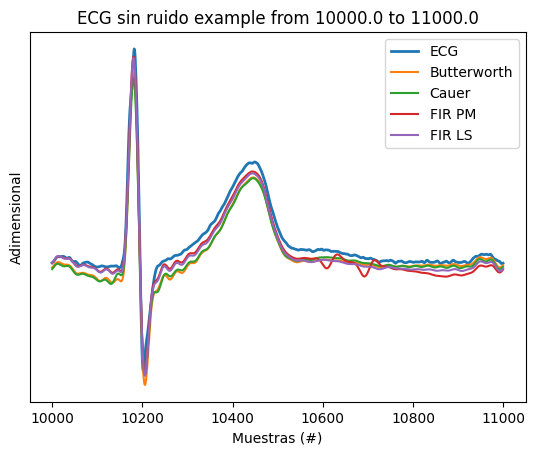

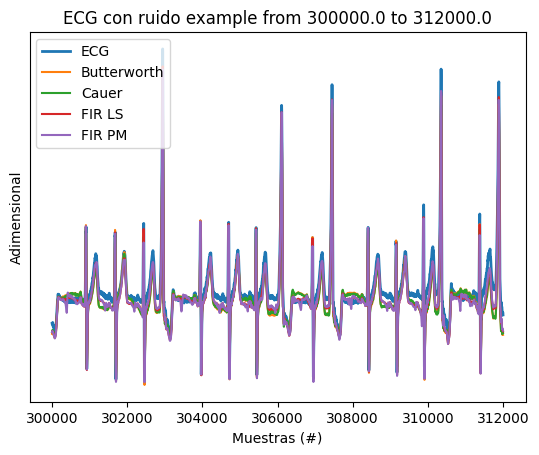

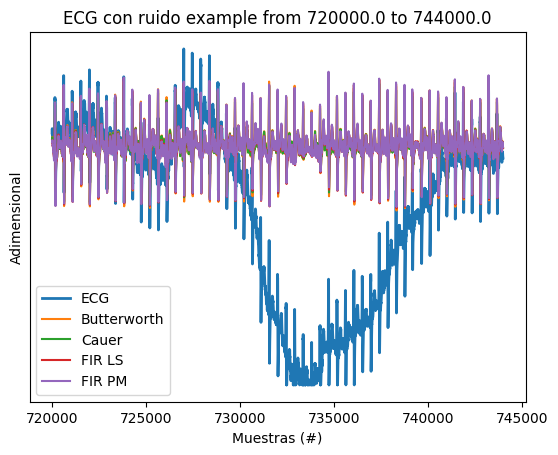

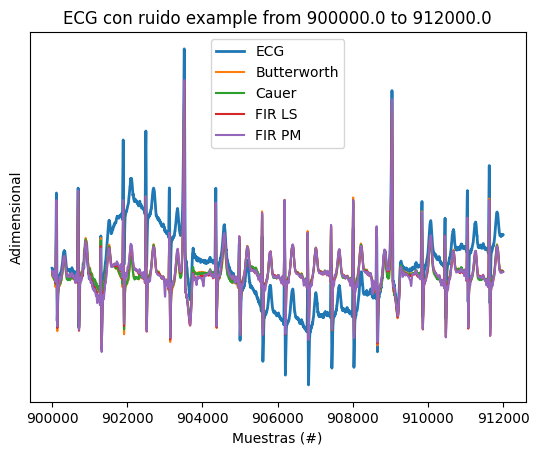

In [8]:
#################
# Lectura de ECG sin ruido
#################

sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten() #registro con fs=1khz
heartbeat_pattern1=mat_struct['heartbeat_pattern1'].flatten() # latido normal
heartbeat_pattern2=mat_struct['heartbeat_pattern2'].flatten()# latido ventricular

N = len(ecg_one_lead)
cant_muestras=N

ecg_filt_butter=sig.sosfiltfilt(mi_sos_butter,ecg_one_lead)
ecg_filt_cauer=sig.sosfiltfilt(mi_sos_cauer,ecg_one_lead)

ecg_filt_ls=sig.lfilter(b=fir_ls, a=1 ,x=ecg_one_lead)
ecg_filt_pm=sig.lfilter(b=fir_pm, a=1 ,x=ecg_one_lead)

##################################
# Regiones de interés sin ruido #
##################################
 
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_filt_pm[zoom_region + retardo_pm], label='FIR PM')
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR LS')
   
    plt.title('ECG sin ruido example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_butter[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')    
    plt.plot(zoom_region, ecg_filt_ls[zoom_region + retardo_ls], label='FIR LS')
    plt.plot(zoom_region, ecg_filt_pm[zoom_region + retardo_pm], label='FIR PM')
   
    plt.title('ECG con ruido example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

1) Zonas con interferencia (gráficos 3, 4 y 5):

En la figura 3, se observa ruido de alta frecuencia de origen muscular (deltas de respuesta impulsiva) y los filtros IIR tienden a oscilar respecto de la línea de base. Además, la señal presenta oscilaciones en los segmentos S y Q que los filtros no suprimen completamente.
En la figura 4, se produce un efecto destructivo, a pesar de la efectividad de los filtros, dado el límite de digitalización en las interferencias de baja frecuencia, por lo cual se recorta la señal de forma irreversible y se situa sobre la línea de base.
En la figura 5, se combinan las interferencias de alta y baja frecuencia mencionadas previamente y los filtros recuperan la línea de base y disminuyen las oscilaciones en dichos segmentos.

3) Zonas sin interferencia (gráficos 1 y 2):

En general, se logra una estabilización de la línea de base gracias a los filtros implementados en conjunto a la compensación de los retardos en los de tipo FIR y a la fase nula en los de tipo IIR, por lo tanto, no se distorisona significativamente el complejo QRS ni las ondas P y T. Sin embargo, existen excepciones tales como las oscilaciones mínimas introducidas por el filtro de Parks-Mc Clellan-Remez posterior al segmento T, donde los otros suprimen el ruido de alta frecuencia generando planicidad, y el rizado impuesto por parte de los filtros IIR en sitios planos pertenecientes a los segmentos S y Q.

# Conclusiones
Finalmente, se deduce del análisis que todas los tipos de filtros, salvo el de cuadrados mínimos que no cumplió la atenuación en el codo de transición posiblemente como consecuencia de una inadecuada configuración de sus pesos, son capaces de satisfacer las condiciones de la plantilla definida. La estrategia para el rendimiento óptimo de los filtros tipo IIR consistió en su implementación bidireccional, así como la característica linealidad de fase de los filtros de clase FIR que logra un carácter inocuo en la morfología general de la señal. 
Además, la evaluación de los filtros implementados sobre el ECG reveló la introducción de artefactos, tales como las oscilaciones del filtro Parks-Mc Clellan en la línea de base respecto al segmento T, probablemente derivado de la alinealidad de la segunda transición, y el rizado de los filtros IIR en los segmentos S y Q. 
En adición, se evidenció un límite del procesamiento a través del efecto destructivo observado en la figura 4, al momento en que la interferencia de baja frecuencia es tan extrema que satura la digitalización y produce un recorte irreversible en la señal. 

# Autoevaluación
A) Sí, resolví la tarea con seguridad.

B) Lo aprendido en esta tarea fueron el diseño filtros FIR e IIR en base a una plantilla de diseño, el análisis de sus respuestas en frecuencia respecto de la plantilla en conjunto a su ajuste mediante diversas técnicas para lograr su cumplimiento, y la evaluación de la efectividad de los filtros aplicados sobre una señal en función de su accionar en la banda de paso con carácter inócuo y en la banda de rechazo suprimiendo las interferencias.

C) No fue utilizada ninguna IA.